In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN, draw_comparative_hist
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random

## Пример на геоданных

In [3]:
geo = pd.read_csv('../datasets/hackathon_processed.csv')
geo.head(10)

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,1815.0,JURASSIC,LIMESTONE,75.0,55.2,21.0,410.0
1,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,EXTENSION,29.7422,28.4925,GUPCO,ONSHORE,GAS-CONDENSATE,MATURE PRODUCTION,RIFT,3084.6,CRETACEOUS,SANDSTONE,223.5,43.2,10.0,8.0
2,ABU MADI-EL QARA,ABU MADI (LEVEL II),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,GAS,DECLINING PRODUCTION,WRENCH,2952.9,NEOGENE,THINLY-BEDDED SANDSTONE,34.5,19.8,22.0,200.0
3,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP,31.4382,31.3616,IEOC,ONSHORE,GAS,DECLINING PRODUCTION,WRENCH,3149.7,NEOGENE,SANDSTONE,152.7,123.0,20.0,300.0
4,AL HUWAISAH,SHUAIBA,OMAN,MIDDLE EAST,FAHUD SALT,COMPRESSION,21.9607,56.0452,PDO,ONSHORE,OIL,REJUVENATING,SALT,1486.5,CRETACEOUS,LIMESTONE,75.0,30.0,21.0,60.0
5,ALABAMA FERRY,UPPER GLEN ROSE D ZONE,USA,NORTH AMERICA,GULF OF MEXICO NORTHERN ONSHORE,GRAVITY,31.2143,-95.7981,NUMEROUS,ONSHORE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,2610.0,CRETACEOUS,LIMESTONE,28.5,4.5,12.0,20.0
6,ALBA,ALBA,UK,EUROPE,NORTH SEA CENTRAL,NaN,58.0692,1.0784,CHEVRON,OFFSHORE,OIL,DECLINING PRODUCTION,RIFT,1692.6,PALEOGENE,THINLY-BEDDED SANDSTONE,90.0,81.0,NaN,3500.0
7,ALBION-SCIPIO,TRENTON-BLACK RIVER,USA,NORTH AMERICA,MICHIGAN,NaN,41.9937,-84.6016,NUMEROUS,ONSHORE,OIL,NEARLY DEPLETED,INTRACRATONIC,1140.0,ORDOVICIAN,DOLOMITE,180.0,120.0,NaN,10.0
8,ALIBEKMOLA,KT I,KAZAKHSTAN,FORMER SOVIET UNION,CASPIAN NORTH,COMPRESSION,48.4740,57.6667,KAZAKHOIL AKTOBE,ONSHORE,OIL,DEVELOPING,SUB-SALT,1800.0,CARBONIFEROUS,LIMESTONE,90.0,31.5,10.0,20.0
9,ALIBEKMOLA,KT II,KAZAKHSTAN,FORMER SOVIET UNION,CASPIAN NORTH,COMPRESSION,48.4740,57.6667,KAZAKHOIL AKTOBE,ONSHORE,OIL,DEVELOPING,SUB-SALT,2874.0,CARBONIFEROUS,LIMESTONE,182.1,32.4,10.0,20.0


In [4]:
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Gross','Netpay','Porosity','Permeability', 'Depth']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [5]:
cont_columns = ['Gross','Netpay','Porosity','Permeability', 'Depth']

In [6]:
geo_coded, label_coder = code_categories(geo, 'label', ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type'])

In [7]:
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', ['Gross','Netpay','Porosity','Permeability', 'Depth'])

In [8]:
geo_only_discrete, discrete_coder = discretization(geo, 'equal_frequency', ['Gross','Netpay','Porosity','Permeability', 'Depth'])

In [9]:
geo_nodes = get_nodes_type(geo)
geo_nodes

{'Tectonic regime': 'disc',
 'Period': 'disc',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Hydrocarbon type': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont'}

In [10]:
bn_geo = structure_learning(geo_discrete, 'HC', 'K2', geo_nodes)

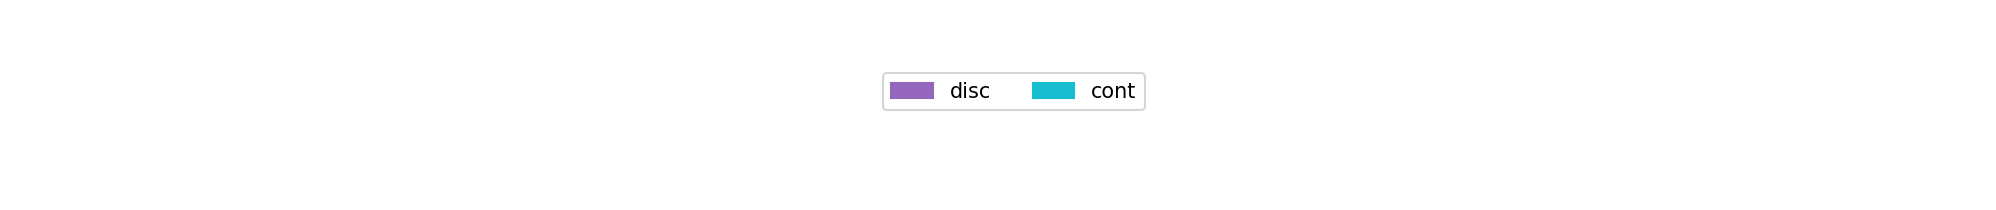

In [11]:
draw_BN(bn_geo, geo_nodes, 'geo_net')

In [11]:
params = parameter_learning(geo, geo_nodes, bn_geo)

In [12]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [15]:
acc, rmse, real_param, pred_param = calculate_acc(geo_bn, geo, columns)

In [16]:
acc

{'Tectonic regime': 0.48,
 'Period': 0.36,
 'Lithology': 0.56,
 'Structural setting': 0.56,
 'Hydrocarbon type': 0.75}

In [17]:
rmse

{'Gross': 308.92,
 'Netpay': 80.93,
 'Porosity': 5.76,
 'Permeability': 925.75,
 'Depth': 854.48}

In [13]:
sample = generate_synthetics(geo_bn, 2000)

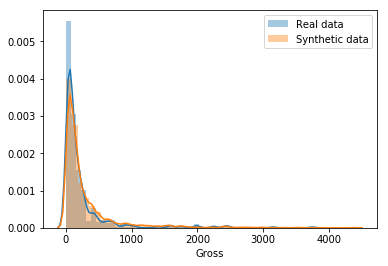

In [14]:
sns.distplot(geo['Gross'], label='Real data')
sns.distplot(sample['Gross'], label='Synthetic data')
plt.legend()

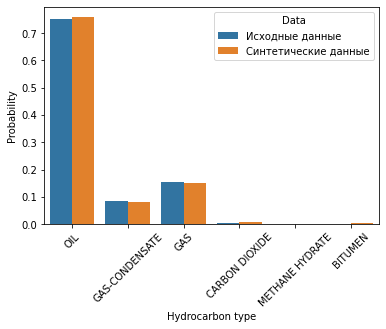

In [15]:
draw_comparative_hist('Hydrocarbon type', geo, sample, geo_nodes)

## Пример на социоданных

In [15]:
socio = pd.read_csv('../datasets/vk_interests_finance.csv')
socio.head(10)

,first_name,last_name,sex,age,city_id,has_high_education,relation,num_of_relatives,followers_count,status,...,top3,top3_mean,game_sum,is_gamer,parent_sum,is_parent,driver_sum,is_driver,pets_sum,has_pets
0,Darya,Tsiberkina,1.0,33,2,0,4,2,486,8,...,5812,1277.784568,0.0,0,9968.00,1,0.0,0,0.0,0
1,Gleb,Kotenev,2.0,18,2,0,0,2,0,5,...,5814,384.000000,0.0,0,0.00,0,0.0,0,0.0,0
2,Anna,Pavlova,1.0,34,2,0,0,2,7,0,...,6011,24000.000000,0.0,0,0.00,0,0.0,0,0.0,0
3,Serega,Martynov,2.0,39,2,0,0,2,7,10,...,5411,142.175000,0.0,0,0.00,0,0.0,0,0.0,0
4,Maria,Pavlyukova,1.0,0,2,0,0,2,144,0,...,6011,1095.238095,0.0,0,60331.59,1,0.0,0,80.0,0
5,Yury,Golubkov,2.0,47,2,0,0,2,0,0,...,5964,760.580000,0.0,0,0.00,0,0.0,0,0.0,0
6,Svetlana,Muratova,1.0,48,2,0,4,2,30,0,...,5411,113.000000,0.0,0,0.00,0,0.0,0,0.0,0
7,Ivan,Poletaev,2.0,0,2,0,0,2,53,23,...,5411,446.565263,1000.0,1,0.00,0,0.0,0,0.0,0
8,Anastasia,Yaguzhinskaya,1.0,25,1,0,0,2,111,3,...,5499,185.523529,0.0,0,0.00,0,0.0,0,1287.0,0
9,Valentina,Trokhova,1.0,55,2,0,0,12,56,0,...,5499,345.572472,0.0,0,0.00,0,0.0,0,0.0,0


In [16]:
columns = ['age', 'sex', 'relation', 'mean_tr', 'median_tr', 'tr_per_month', 'is_parent', 'is_driver', 'has_pets']

In [17]:
socio = socio[columns]
socio.dropna(inplace=True)
socio.reset_index(inplace=True, drop=True)

In [18]:
socio = socio.loc[socio['age'] > 0]

In [19]:
socio['age'] = socio['age'].apply(lambda x: float(x))
socio['sex'] = socio['sex'].apply(lambda x: str(x))
socio['relation'] = socio['relation'].apply(lambda x: str(x))
socio['is_parent'] = socio['is_parent'].apply(lambda x: str(x))
socio['is_driver'] = socio['is_driver'].apply(lambda x: str(x))
socio['has_pets'] = socio['has_pets'].apply(lambda x: str(x))

In [20]:
socio_types = get_nodes_type(socio)
socio_types

{'age': 'cont',
 'sex': 'disc',
 'relation': 'disc',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 'tr_per_month': 'cont',
 'is_parent': 'disc',
 'is_driver': 'disc',
 'has_pets': 'disc'}

In [21]:
discrete_socio, coder_socio = discretization(socio, 'equal_frequency', ['age', 'mean_tr', 'median_tr', 'tr_per_month'])

In [22]:
bn_socio = structure_learning(discrete_socio, 'HC', 'K2', socio_types)

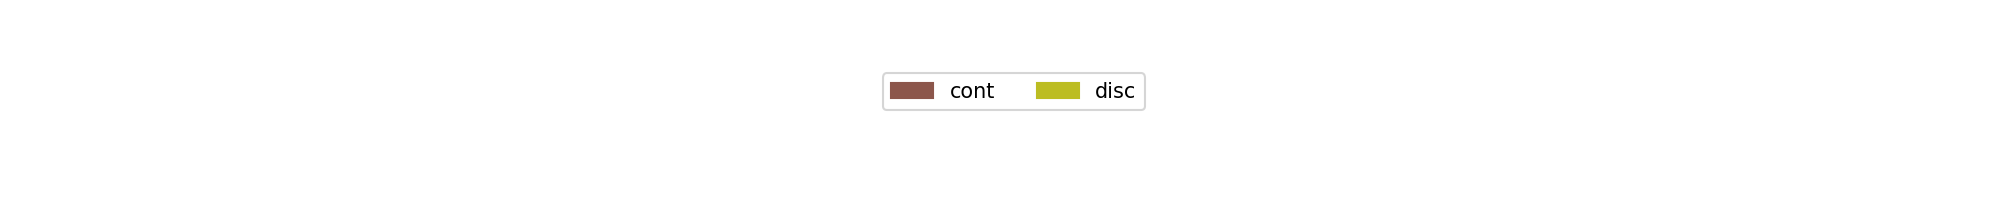

In [23]:
draw_BN(bn_socio, socio_types, 'socio_net')

In [47]:
params = parameter_learning(socio, socio_types, bn_socio)

In [48]:
save_structure(bn_socio, 'socio_net')
skel = read_structure('socio_net')
save_params(params, 'socio_net_param')
params = read_params('socio_net_param')
socio_bn = HyBayesianNetwork(skel, params)

In [49]:
sample = generate_synthetics(socio_bn, 2000)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


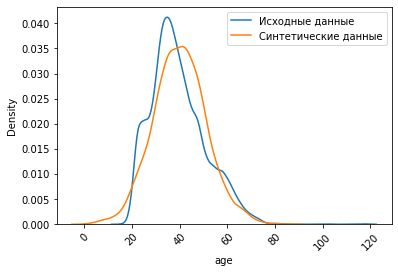

In [50]:
draw_comparative_hist('age', socio, sample, socio_types)

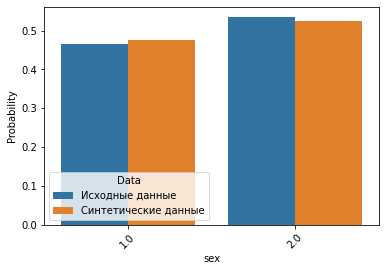

In [53]:
draw_comparative_hist('sex', socio.sample(1000), sample, socio_types)